# Example: CitiBike data

Adapted from Kelsey Jordahl
https://gist.github.com/kjordahl/5957573

In [1]:
import requests  
import json
from pyproj import Proj
from shapely.geometry import Point
import geopandas as gp

NYC borough boundaries downloaded from [Bytes of the Big Apple](http://www.nyc.gov/html/dcp/download/bytes/nybb_13a.zip)

In [2]:
boros = gp.GeoDataFrame.from_file('nybb_15b/nybb.shp')

Load real time bike station data from [CitiBike](http://citibikenyc.com) json API:

In [3]:
# get the bike data and convert it to a ditcionary
endpoint_url = 'http://citibikenyc.com/stations/json'
response = requests.get(endpoint_url)
data = json.loads(response.text)


In [4]:
# convert the relevant part to a geodataframe
df = gp.GeoDataFrame(data['stationBeanList'])
df.head()

,altitude,availableBikes,availableDocks,city,id,landMark,lastCommunicationTime,latitude,location,longitude,postalCode,stAddress1,stAddress2,stationName,statusKey,statusValue,testStation,totalDocks
0,,24,38,,281,,2019-03-08 10:49:03 AM,40.764397,,-73.973715,,Grand Army Plaza & Central Park S,,Grand Army Plaza & Central Park S,1,In Service,False,66
1,,16,15,,304,,2019-03-08 10:46:18 AM,40.704633,,-74.013617,,Broadway & Battery Pl,,Broadway & Battery Pl,1,In Service,False,33
2,,11,51,,359,,2019-03-08 10:48:31 AM,40.755103,,-73.974987,,E 47 St & Park Ave,,E 47 St & Park Ave,1,In Service,False,64
3,,14,31,,377,,2019-03-08 10:48:53 AM,40.722438,,-74.005664,,6 Ave & Canal St,,6 Ave & Canal St,1,In Service,False,45
4,,12,27,,402,,2019-03-08 10:49:29 AM,40.740343,,-73.989551,,Broadway & E 22 St,,Broadway & E 22 St,3,Not In Service,False,39


In [5]:
# there is one row for each bike station.  How many stations are there? 
len(df)

816

In [7]:
# in the file above, there are lon-lats, but no geometry field
# we need to set that up

s = gp.GeoSeries([Point(x, y) for x, y in zip(df['longitude'], df['latitude'])])
df['geometry'] = s
df.crs = {'init': 'epsg:4326', 'no_defs': True}
df.geometry.total_bounds

array([-74.0836394 ,  40.65539977, -73.9077436 ,  40.81439444])

In [8]:
# make sure they are on the same CRS.  
# checking the bounds is a nice way of seeing this
df.to_crs(boros.crs, inplace=True)
df.geometry.total_bounds

array([ 961064.73659426,  178056.37414829, 1009803.53178432,
        235986.42166716])

In [9]:
boros

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330466.075042,1.623827e+09,(POLYGON ((970217.0223999023 145643.3322143555...
1,3,Brooklyn,741185.900596,1.937597e+09,(POLYGON ((1021176.479003906 151374.7969970703...
2,4,Queens,897040.298576,3.045168e+09,(POLYGON ((1029606.076599121 156073.8142089844...
3,1,Manhattan,358408.460709,6.364467e+08,(POLYGON ((981219.0557861328 188655.3157958984...
4,2,Bronx,464400.198868,1.186973e+09,(POLYGON ((1012821.805786133 229228.2645874023...


In [12]:
# the geometry objects can do lots of cool stuff.  For example: 

manhattan = boros.geometry[3]
in_mn = df.geometry.within(manhattan)
print(sum(in_mn), 'stations in Manhattan')

417 stations in Manhattan


# Your turn

You can read about the range of operations available in geopandas here: 
    
http://geopandas.org/index.html

Your assignment is to: 

1. Calculate how many stations are in each borough
2. Calculate how many bikes are currently available in each borough
3. Read about and try at least two new spatial or geometric operations (beyond what I've covered here). 

In [13]:
manhattan = boros.geometry[3]
in_mn = df.geometry.within(manhattan)
print(sum(in_mn), 'stations in Manhattan')

417 stations in Manhattan


In [14]:
bronx = boros.geometry[4]
in_mn = df.geometry.within(bronx)
print(sum(in_mn), 'stations in bronx')

0 stations in bronx


In [15]:
queens = boros.geometry[2]
in_mn = df.geometry.within(queens)
print(sum(in_mn), 'stations in queens')

82 stations in queens


In [16]:
brooklyn = boros.geometry[1]
in_mn = df.geometry.within(brooklyn)
print(sum(in_mn), 'stations in brooklyn')

267 stations in brooklyn


In [17]:
staten_island = boros.geometry[0]
in_mn = df.geometry.within(staten_island)
print(sum(in_mn), 'stations in staten island')

0 stations in staten island


In [18]:
staten_island = boros.geometry[0]
in_mn = df.geometry.within(staten_island)
print(sum(df['availableBikes'][in_mn]))

0


In [19]:
brooklyn = boros.geometry[1]
in_mn = df.geometry.within(brooklyn)
print(sum(df['availableBikes'][in_mn]))

3869


In [20]:
queens = boros.geometry[2]
in_mn = df.geometry.within(queens)
print(sum(df['availableBikes'][in_mn]))

432


In [21]:
manhattan = boros.geometry[3]
in_mn = df.geometry.within(manhattan)
print(sum(df['availableBikes'][in_mn]))

6567


In [22]:
bronx = boros.geometry[4]
in_mn = df.geometry.within(bronx)
print(sum(df['availableBikes'][in_mn]))

0


In [23]:
#spatial operation: example 1
#Spatial Joins
#In a Spatial Join, two geometry objects are merged based on their spatial relationship to one another
# One GeoDataFrame of NYC bounduries, one of citibike.
# Want to merge so we can get each availablebikes in the station.

boros.head()

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330466.075042,1.623827e+09,(POLYGON ((970217.0223999023 145643.3322143555...
1,3,Brooklyn,741185.900596,1.937597e+09,(POLYGON ((1021176.479003906 151374.7969970703...
2,4,Queens,897040.298576,3.045168e+09,(POLYGON ((1029606.076599121 156073.8142089844...
3,1,Manhattan,358408.460709,6.364467e+08,(POLYGON ((981219.0557861328 188655.3157958984...
4,2,Bronx,464400.198868,1.186973e+09,(POLYGON ((1012821.805786133 229228.2645874023...


In [24]:
df.head()

,altitude,availableBikes,availableDocks,city,id,landMark,lastCommunicationTime,latitude,location,longitude,postalCode,stAddress1,stAddress2,stationName,statusKey,statusValue,testStation,totalDocks,geometry
0,,24,38,,281,,2019-03-08 10:49:03 AM,40.764397,,-73.973715,,Grand Army Plaza & Central Park S,,Grand Army Plaza & Central Park S,1,In Service,False,66,POINT (991531.3832799405 217768.3118964672)
1,,16,15,,304,,2019-03-08 10:46:18 AM,40.704633,,-74.013617,,Broadway & Battery Pl,,Broadway & Battery Pl,1,In Service,False,33,POINT (980474.5127561709 195993.6964498408)
2,,11,51,,359,,2019-03-08 10:48:31 AM,40.755103,,-73.974987,,E 47 St & Park Ave,,E 47 St & Park Ave,1,In Service,False,64,POINT (991179.9038325883 214381.943780388)
3,,14,31,,377,,2019-03-08 10:48:53 AM,40.722438,,-74.005664,,6 Ave & Canal St,,6 Ave & Canal St,1,In Service,False,45,POINT (982679.8907825906 202480.2214391762)
4,,12,27,,402,,2019-03-08 10:49:29 AM,40.740343,,-73.989551,,Broadway & E 22 St,,Broadway & E 22 St,3,Not In Service,False,39,POINT (987145.5291465931 209003.7784183958)


In [25]:
common = gp.sjoin(df, boros, how="inner", op='intersects')
common

,altitude,availableBikes,availableDocks,city,id,landMark,lastCommunicationTime,latitude,location,longitude,...,statusKey,statusValue,testStation,totalDocks,geometry,index_right,BoroCode,BoroName,Shape_Leng,Shape_Area
0,,24,38,,281,,2019-03-08 10:49:03 AM,40.764397,,-73.973715,...,1,In Service,False,66,POINT (991531.3832799405 217768.3118964672),3,1,Manhattan,358408.460709,6.364467e+08
1,,16,15,,304,,2019-03-08 10:46:18 AM,40.704633,,-74.013617,...,1,In Service,False,33,POINT (980474.5127561709 195993.6964498408),3,1,Manhattan,358408.460709,6.364467e+08
2,,11,51,,359,,2019-03-08 10:48:31 AM,40.755103,,-73.974987,...,1,In Service,False,64,POINT (991179.9038325883 214381.943780388),3,1,Manhattan,358408.460709,6.364467e+08
3,,14,31,,377,,2019-03-08 10:48:53 AM,40.722438,,-74.005664,...,1,In Service,False,45,POINT (982679.8907825906 202480.2214391762),3,1,Manhattan,358408.460709,6.364467e+08
4,,12,27,,402,,2019-03-08 10:49:29 AM,40.740343,,-73.989551,...,3,Not In Service,False,39,POINT (987145.5291465931 209003.7784183958),3,1,Manhattan,358408.460709,6.364467e+08
5,,13,18,,487,,2019-03-08 10:46:55 AM,40.733143,,-73.975739,...,1,In Service,False,34,POINT (990973.8184738184 206381.12757902),3,1,Manhattan,358408.460709,6.364467e+08
6,,0,16,,3255,,2019-03-08 10:49:18 AM,40.750585,,-73.994685,...,1,In Service,False,19,POINT (985722.6805079071 212735.1920977242),3,1,Manhattan,358408.460709,6.364467e+08
7,,8,33,,3443,,2019-03-08 10:46:30 AM,40.761330,,-73.979820,...,1,In Service,False,41,POINT (989840.3759118057 216650.3564584734),3,1,Manhattan,358408.460709,6.364467e+08
8,,32,22,,72,,2019-03-08 10:46:14 AM,40.767272,,-73.993929,...,1,In Service,False,55,POINT (985931.7065028953 218814.7571059955),3,1,Manhattan,358408.460709,6.364467e+08
9,,23,9,,79,,2019-03-08 10:47:45 AM,40.719116,,-74.006667,...,1,In Service,False,33,POINT (982402.0068864139 201269.770346975),3,1,Manhattan,358408.460709,6.364467e+08


In [26]:
len(common)

766

In [27]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gp
from shapely.geometry import Point
import pandas as pd

In [28]:
#spatial operation: example 2
# when working with spatial data, we need a special tool that can also aggregate geometric features. 
#In the geopandas library, that functionality is provided by the dissolve function.
#If we are interested in aggregate populations, however, we can pass different functions to the dissolve method to aggregate populations:
boros = gp.read_file('nybb_15b/nybb.shp')
boros

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330466.075042,1.623827e+09,(POLYGON ((970217.0223999023 145643.3322143555...
1,3,Brooklyn,741185.900596,1.937597e+09,(POLYGON ((1021176.479003906 151374.7969970703...
2,4,Queens,897040.298576,3.045168e+09,(POLYGON ((1029606.076599121 156073.8142089844...
3,1,Manhattan,358408.460709,6.364467e+08,(POLYGON ((981219.0557861328 188655.3157958984...
4,2,Bronx,464400.198868,1.186973e+09,(POLYGON ((1012821.805786133 229228.2645874023...


In [29]:
# set the index to be the name of the borough, and sort in order of the borough code
boros.reset_index(inplace=True)
boros.set_index('BoroName', inplace=True)
boros.sort_values(by='BoroCode', inplace=True)
boros


,index,BoroCode,Shape_Leng,Shape_Area,geometry
BoroName,,,,,
Manhattan,3,1,358408.460709,6.364467e+08,(POLYGON ((981219.0557861328 188655.3157958984...
Bronx,4,2,464400.198868,1.186973e+09,(POLYGON ((1012821.805786133 229228.2645874023...
Brooklyn,1,3,741185.900596,1.937597e+09,(POLYGON ((1021176.479003906 151374.7969970703...
Queens,2,4,897040.298576,3.045168e+09,(POLYGON ((1029606.076599121 156073.8142089844...
Staten Island,0,5,330466.075042,1.623827e+09,(POLYGON ((970217.0223999023 145643.3322143555...


In [30]:
population = pd.Series({'Manhattan': 1585873, 'Bronx': 1385108, 'Brooklyn': 2504700,
                     'Queens': 2230722, 'Staten Island': 468730})
population

Manhattan        1585873
Bronx            1385108
Brooklyn         2504700
Queens           2230722
Staten Island     468730
dtype: int64

In [31]:
boros['population'] = population
boros

,index,BoroCode,Shape_Leng,Shape_Area,geometry,population
BoroName,,,,,,
Manhattan,3,1,358408.460709,6.364467e+08,(POLYGON ((981219.0557861328 188655.3157958984...,1585873
Bronx,4,2,464400.198868,1.186973e+09,(POLYGON ((1012821.805786133 229228.2645874023...,1385108
Brooklyn,1,3,741185.900596,1.937597e+09,(POLYGON ((1021176.479003906 151374.7969970703...,2504700
Queens,2,4,897040.298576,3.045168e+09,(POLYGON ((1029606.076599121 156073.8142089844...,2230722
Staten Island,0,5,330466.075042,1.623827e+09,(POLYGON ((970217.0223999023 145643.3322143555...,468730


In [32]:
boros.head()

,index,BoroCode,Shape_Leng,Shape_Area,geometry,population
BoroName,,,,,,
Manhattan,3,1,358408.460709,6.364467e+08,(POLYGON ((981219.0557861328 188655.3157958984...,1585873
Bronx,4,2,464400.198868,1.186973e+09,(POLYGON ((1012821.805786133 229228.2645874023...,1385108
Brooklyn,1,3,741185.900596,1.937597e+09,(POLYGON ((1021176.479003906 151374.7969970703...,2504700
Queens,2,4,897040.298576,3.045168e+09,(POLYGON ((1029606.076599121 156073.8142089844...,2230722
Staten Island,0,5,330466.075042,1.623827e+09,(POLYGON ((970217.0223999023 145643.3322143555...,468730


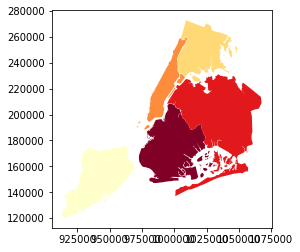

In [34]:
boros1 = boros[['BoroCode', 'geometry', 'population']]

agg = boros1.dissolve(by='BoroCode', aggfunc='sum')

base = agg.plot(column = 'population', scheme='quantiles', cmap='YlOrRd');

base
